# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

In [1]:
!pip install fastai2

In [2]:
!pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI

In [0]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from monai.losses import FocalLoss
import gc

### fastai U-Net on these static images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/miccai2020/myops/png"

In [6]:
np.random.seed(42)
ids = np.arange(101,151)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,10))
ids

array([[114, 140, 131, 146, 118, 149, 127, 126, 133, 120],
       [113, 105, 138, 109, 104, 107, 142, 147, 148, 116],
       [110, 117, 125, 135, 132, 101, 145, 128, 134, 106],
       [130, 112, 137, 102, 122, 103, 144, 136, 124, 141],
       [111, 123, 119, 150, 121, 108, 143, 115, 129, 139]])

Use cropping instead of resizing

In [0]:
class AddMaskCodeMapping(Transform):
    "Add mapping of pixel value to class for a `TensorMask`"
    def __init__(self, mapping, codes=None):
        self.mapping = mapping
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def decodes(self, o:TensorMask):
        mo = self.mapping.index_select(0,o.flatten()).reshape(*o.shape)
        if self.codes is not None: mo._meta = {'codes': self.codes}
        return mo

In [0]:
def MappedMaskBlock(mapping,codes=None):
    "A `TransformBlock` for segmentation masks, with mapping of pixel values to classes, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodeMapping(mapping=mapping,codes=codes), batch_tfms=IntToFloatTensor)

In [0]:
def getMyopsDls(val_ids):
  myopsData = DataBlock(blocks=(ImageBlock, MappedMaskBlock(mapping = torch.LongTensor([0,1,1,1,2,1]), codes = ['bg','heart','ed'])),#['bg','lv','my','rv','ed','sc'])),
      get_items=get_image_files,
      splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in val_ids),
      get_y=lambda o: str(o).replace("images","masks"),
      item_tfms=CropPad(256),
      batch_tfms=aug_transforms(max_rotate=90))
  return myopsData.dataloaders(f'{path}/images',num_workers=8,batch_size=9)

In [0]:
dl = getMyopsDls(ids[0])

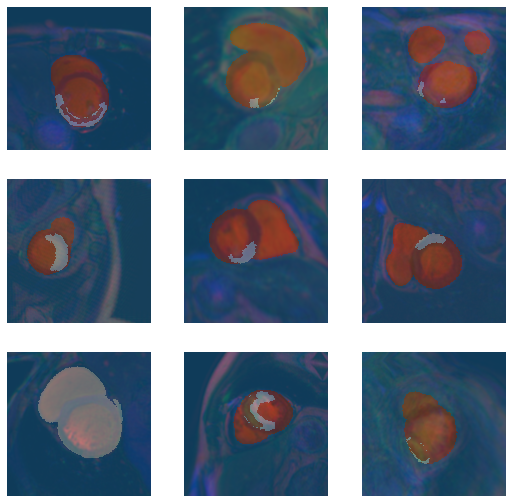

In [16]:
dl.show_batch()

In [0]:
# The lower left one does not look right
from glob import glob

In [0]:
orig_masks = glob(path+'/masks/*orig*.png')

In [0]:
from tqdm.notebook import tqdm

In [27]:
histos = []
for m in tqdm(orig_masks):
  hist = {a.item(): b.item() for a,b in zip(*torch.unique(ToTensor()(OpenMask(m)), return_counts=True))}
  hist['file'] = Path(m).name
  histos.append(hist)

In [32]:
histos = pd.DataFrame(histos)
histos.head()

,0,1,2,3,4,5,file
0,254375,1986,1556,1104.0,1588.0,512.0,102-orig-0.png
1,248621,3725,1750,4445.0,1746.0,834.0,102-orig-1.png
2,244384,4809,1708,6931.0,2068.0,1221.0,102-orig-2.png
3,224731,803,1710,1607.0,1067.0,NaN,104-orig-0.png
4,222434,1244,1907,3199.0,1134.0,NaN,104-orig-1.png


In [0]:
histos = histos.set_index('file').rename(columns={0:"bg",1:"lv",2:"my",3:"rv",4:"edema",5:"scar"})

In [64]:
print(histos.mean())
print(histos.max())

bg       220876.715686
lv         2543.539216
my         2448.235294
rv         3368.891304
edema       718.620690
scar        865.247191
dtype: float64
bg       254375.0
lv         4946.0
my         4841.0
rv         8219.0
edema      2068.0
scar       2611.0
dtype: float64


In [0]:
histos_long = histos.fillna(0).stack().reset_index()
histos_long.columns = ['file','class','pixels']

In [0]:
import altair as alt

In [63]:
(alt.Chart(histos_long[histos_long['class']!='bg'])
  .mark_boxplot()
  .encode(x='class', y='pixels', color='class')
  .properties(width=600, height=300)
  .interactive()
)

alt.Chart(...)

In [66]:
# percentage of classes in the full images (this is different in the cropped ones -> less bg)
histos.sum()/histos.sum().sum()

bg       0.959187
lv       0.011046
my       0.010632
rv       0.013196
edema    0.002662
scar     0.003279
dtype: float64

**Attention!** The cropped version can have masks close to the edge and zooming or rotation can lead to additional masks at the edge because of padding in reflection mode

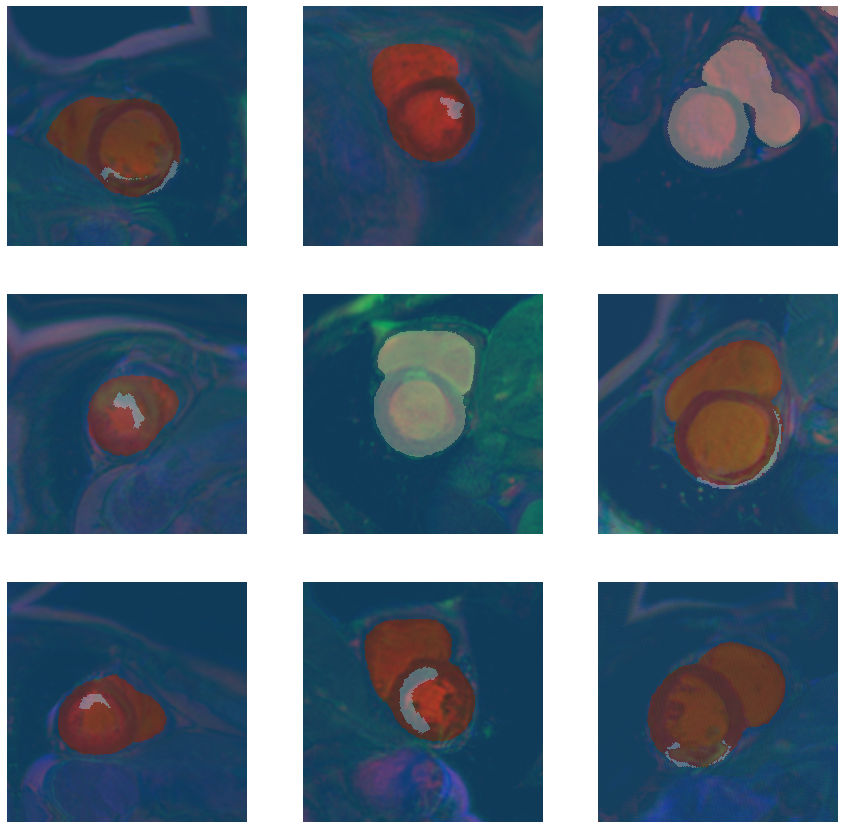

In [70]:
getMyopsDls(ids[0]).show_batch(figsize=(15,15))

In [0]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceHeart(input, targs): return multi_dice(input,targs,class_id=1)
def diceEdema(input, targs): return multi_dice(input,targs,class_id=2)
dices = [diceHeart,diceEdema]

In [0]:
monaiFocal = FocalLoss(weight=torch.Tensor([.1,.2,.7]),reduction='mean')
def myFocal(input, target):
  return monaiFocal(input, target.unsqueeze(1))

In [0]:
def standard_trained_learner_cv(dl):
  learn = unet_learner(
    dl,
    resnet34,
    loss_func=myFocal,
    metrics=[foreground_acc, *dices],
    cbs=CSVLogger(fname="/content/drive/My Drive/miccai2020/myops/04_crop_focal_edOnly_unet_resnet34.trainLog.csv",append=True)
  )
  learn.lr_find()
  learn.fit_one_cycle(10,lr_max=1e-3)
  learn.unfreeze()
  learn.lr_find()
  learn.fit_one_cycle(10,lr_max=1e-4)
  return learn

In [13]:
cv_results = list()
learn = None
dl = None
for x in ids:
  del learn
  del dl
  gc.collect()
  torch.cuda.empty_cache()
  dl = getMyopsDls(x)
  learn = standard_trained_learner_cv(dl)
  cv_results.append(learn.validate())

RuntimeError: ignored

In [13]:
cv_results = pd.DataFrame(cv_results, columns=learn.recorder.metric_names[2:-1])
cv_results

,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc
0,0.007916,0.785653,0.860366,0.744840,0.823688,0.278227,0.548672
1,0.009046,0.787138,0.866435,0.698511,0.817476,0.216515,0.430518
2,0.007389,0.767570,0.857543,0.720460,0.751581,0.248524,0.497951
3,0.008067,0.797787,0.884918,0.697286,0.851157,0.268706,0.538122
4,0.010989,0.751046,0.859032,0.663768,0.796011,0.270548,0.512823


In [0]:
cv_results.to_csv('/content/drive/My Drive/miccai2020/myops/04_crop_focal_edOnly_unet_resnet34.cv_results.csv', index=False)

In [15]:
cv_results.mean()

valid_loss        0.008681
foreground_acc    0.777839
diceLV            0.865659
diceMY            0.704973
diceRV            0.807983
diceEd            0.256504
diceSc            0.505617
dtype: float64

In [0]:
cv_results_long = cv_results.stack().reset_index()
cv_results_long.columns = ['cv', 'metric', 'value']

In [0]:
import altair as alt

In [18]:
(alt.Chart(cv_results_long)
  .mark_point()
  .encode(x='metric', y='value', color='cv:N')
  .properties(width=600, height=300)
  .interactive())

alt.Chart(...)

TypeError: ignored

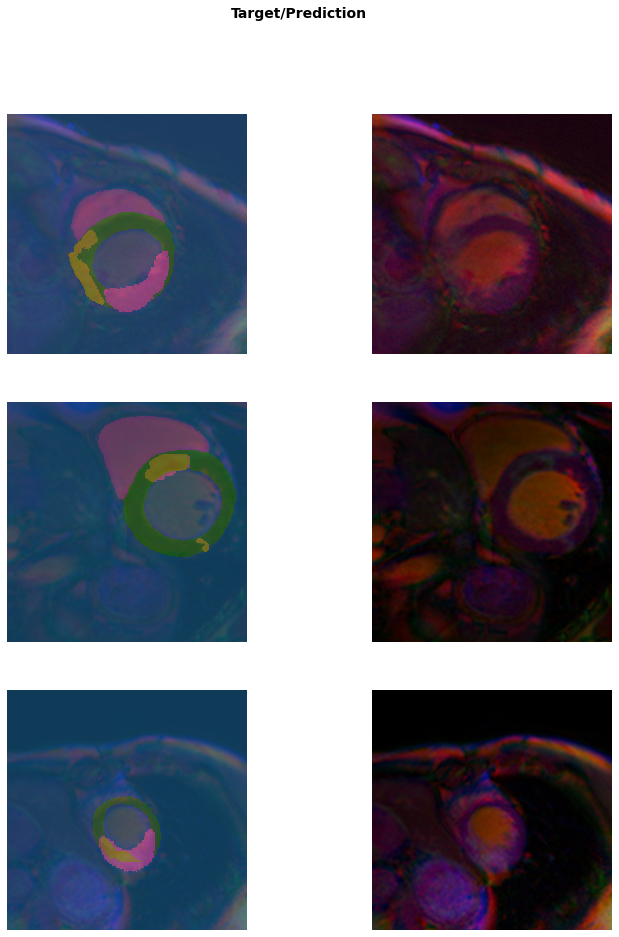

In [19]:
learn.show_results(figsize=(12,15))

In [0]:
learn.show_results(ds_idx=0, figsize=(15,15))

In [20]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [21]:
%%R

library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)



# A tibble: 5 x 7
  valid_loss foreground_acc diceLV diceMY diceRV diceEd diceSc
       <dbl>          <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1    0.00792          0.786  0.860  0.745  0.824  0.278  0.549
2    0.00905          0.787  0.866  0.699  0.817  0.217  0.431
3    0.00739          0.768  0.858  0.720  0.752  0.249  0.498
4    0.00807          0.798  0.885  0.697  0.851  0.269  0.538
5    0.0110           0.751  0.859  0.664  0.796  0.271  0.513


In [35]:
%%R
read_cv_results <- function(name) {
    return(
        read_csv(paste0("/content/drive/My Drive/miccai2020/myops/",name,".cv_results.csv")) %>%
          mutate(cv=as_factor(row_number()),name=name)
    )
}
cv_res <- bind_rows(
    read_cv_results("00_simple_unet_resnet34"),
    read_cv_results("00_crop_unet_resnet34"),
    read_cv_results("03_crop_focal_unet_resnet34"),
    read_cv_results("03_crop_focal2_unet_resnet34"),
    read_cv_results("03_crop_focal3_unet_resnet34"),
)

cv_res

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)



# A tibble: 25 x 9
   valid_loss foreground_acc diceLV diceMY diceRV diceEd diceSc cv    name      
        <dbl>          <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <fct> <chr>     
 1     0.0257          0.798  0.878  0.746  0.866  0.240  0.487 1     00_simple…
 2     0.0288          0.803  0.865  0.726  0.837  0.150  0.433 2     00_simple…
 3     0.0275          0.775  0.863  0.743  0.772  0.286  0.496 3     00_simple…
 4     0.0311          0.800  0.897  0.726  0.854  0.221  0.518 4     00_simple…
 5     0.0367          0.758  0.852  0.670  0.795  0.223  0.425 5     00_simple…
 6     0.0852          0.805  0.880  0.778  0.829  0.247  0.491 1     00_crop_u…
 7     0.105           0.818  0.874  0.744  0.819  0.136  0.428 2     00_crop_u…
 8     0.0893          0.789  0.879  0.757  0.787  0.295  0.524 3     00_crop_u…
 9     0.0979          0.812  0.897  0.727  0.848  0.185  0.511 4     00_crop_u…
10     0.123           0.773  0.873  0.699  0.811  0.253  0.494 5     00_crop_u…
# … with 

In [36]:
%%R
cv_res %>% group_by(name) %>% select(-cv) %>% summarize_all(mean)

# A tibble: 5 x 8
  name              valid_loss foreground_acc diceLV diceMY diceRV diceEd diceSc
  <chr>                  <dbl>          <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1 00_crop_unet_res…    0.100            0.799  0.881  0.741  0.819  0.223  0.489
2 00_simple_unet_r…    0.0300           0.787  0.871  0.722  0.825  0.224  0.472
3 03_crop_focal_un…    0.0237           0.793  0.881  0.737  0.809  0.220  0.501
4 03_crop_focal2_u…    0.0126           0.798  0.877  0.738  0.806  0.253  0.513
5 03_crop_focal3_u…    0.00868          0.778  0.866  0.705  0.808  0.257  0.506


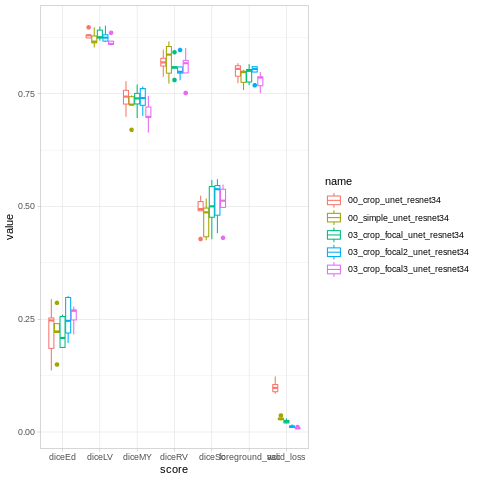

In [50]:
%%R
cv_res %>%
  gather("score","value",valid_loss:diceSc) %>%
  ggplot(aes(score,value,color=name)) +
  geom_boxplot() +
  theme_light()

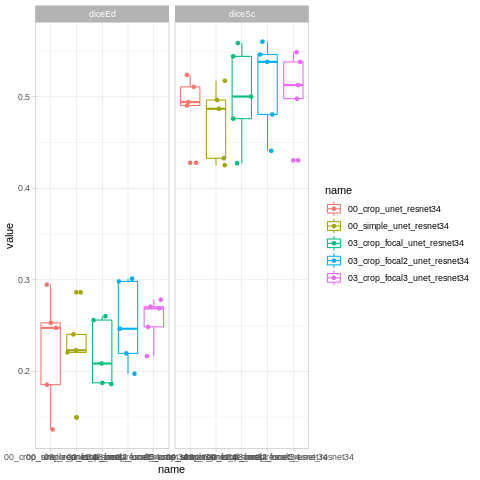

In [44]:
%%R
cv_res %>%
  gather("score","value",valid_loss:diceSc) %>%
  filter(score %in% c("diceSc","diceEd")) %>%
  ggplot(aes(name,value,color=name)) +
  geom_boxplot() +
  geom_jitter() +
  facet_wrap(score ~ .) +
  theme_light()

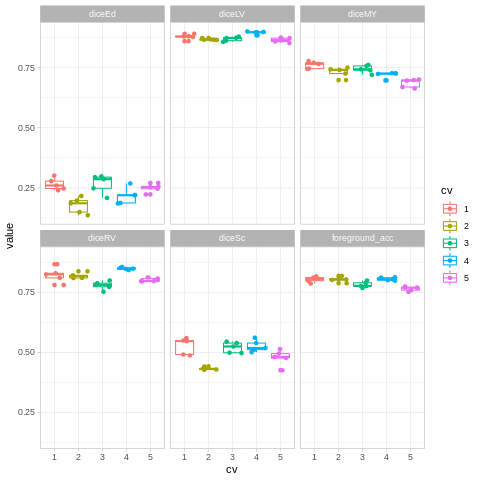

In [49]:
%%R
cv_res %>%
  gather("score","value",valid_loss:diceSc) %>%
  filter(score != "valid_loss") %>%
  ggplot(aes(cv,value,color=cv)) +
  geom_boxplot() +
  geom_jitter() +
  facet_wrap(score ~ .) +
  theme_light()